In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn

from pathlib import Path

In [67]:
dataset = "normals"
pred = "stumps-optimal"
prior = 0.1
lrs = [0.01]

In [68]:
results = {}
for risk in ["exact", "MC"]:
    
    load_dir = Path(f"../results/{risk}/{pred}/{dataset}/prior={prior}/")
    r = {l: np.load(next(load_dir.rglob(f'lr={l}/**/results.npy')), allow_pickle=True).item() for l in lrs}
    
    results[risk] = r

<AxesSubplot:xlabel='n-values', ylabel='time'>

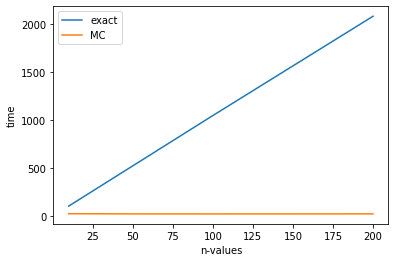

In [69]:
sn.lineplot(data=results["exact"][0.01], x="n-values", y="time", label="exact")
sn.lineplot(data=results["MC"][0.01], x="n-values", y="time", label="MC")

# plt.yscale("log")

<AxesSubplot:xlabel='n-values', ylabel='test-error'>

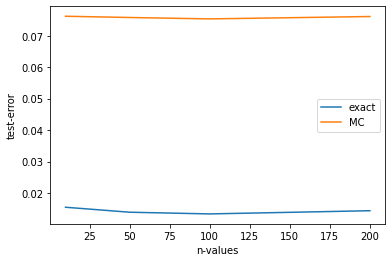

In [70]:
sn.lineplot(data=results["exact"][0.01], x="n-values", y="test-error", label="exact")
sn.lineplot(data=results["MC"][0.01], x="n-values", y="test-error", label="MC")

In [74]:
dataset = "normals"
pred = "stumps-uniform"
prior = 0.1
lrs = [0.1]

results = {}
for risk in ["exact", "MC"]:
    
    load_dir = Path(f"../results/{risk}/{pred}/{dataset}/prior={prior}/")
    r = {l: np.load(next(load_dir.rglob(f'lr={l}/**/results.npy')), allow_pickle=True).item() for l in lrs}
    
    results[risk] = r

<AxesSubplot:xlabel='m-values', ylabel='time'>

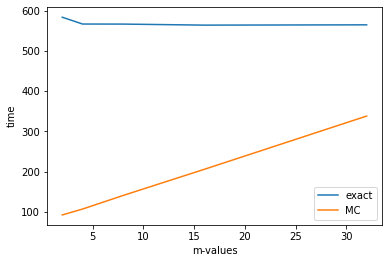

In [75]:
sn.lineplot(data=results["exact"][0.1], x="m-values", y="time", label="exact")
sn.lineplot(data=results["MC"][0.1], x="m-values", y="time", label="MC")

# plt.yscale("log")

<AxesSubplot:xlabel='m-values', ylabel='test-error'>

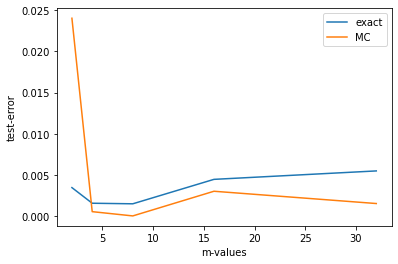

In [76]:
sn.lineplot(data=results["exact"][0.1], x="m-values", y="test-error", label="exact")
sn.lineplot(data=results["MC"][0.1], x="m-values", y="test-error", label="MC")

In [2]:
M = 4
ns = [10, 100, 1000]
ts = [1, 5, 10, 20, 40, 80, 100]
methods = ["exact", "MC"]
bound = "seeger"
seeds = "541713-541723"

load_dir = Path(f"../results/latest/moons/")

results = {}
for n in ns:
    c_dir = load_dir / f"{n}/MC/{bound}/optimize-bound=True/stumps-uniform/M=4/"
    
    results[n] = {}
    results[n]["MC"] = {}
    for t in ts:
        path = next(c_dir.rglob(f"**/seeds={seeds}/MC={t}/*.npy"))
        results[n]["MC"][t] = np.load(path, allow_pickle=True).item()
    
    c_dir = load_dir / f"{n}/exact/{bound}/optimize-bound=True/stumps-uniform/M=4/"
    results[n]["exact"] = {}
    path = next(c_dir.rglob(f"**/seeds={seeds}/*.npy"))
    results[n]["exact"] = np.load(path, allow_pickle=True).item()

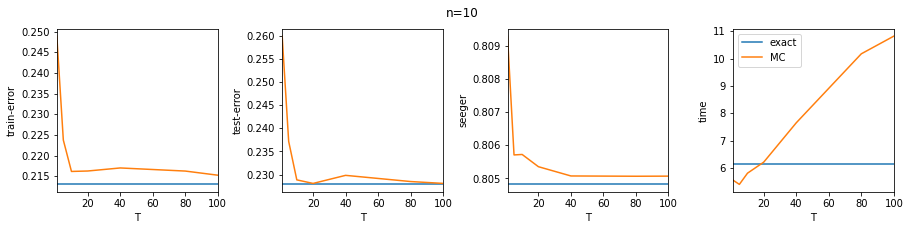

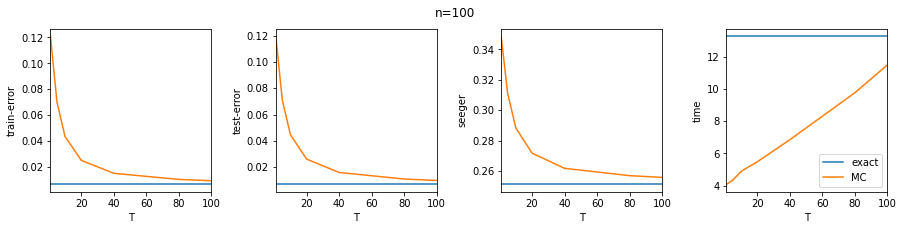

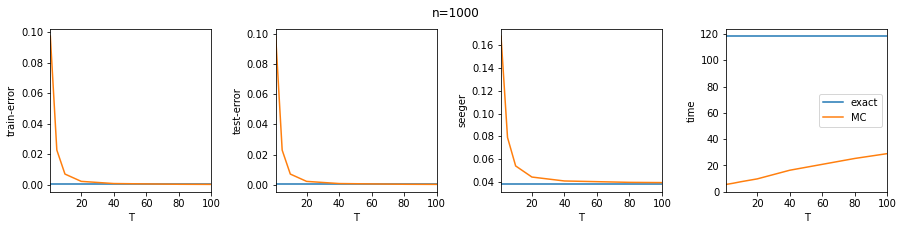

In [3]:
b = "seeger"

for n in ns:
    plt.figure(figsize=(15,3))

    for j, e in enumerate(["train-error", "test-error", b, "time"]):
        ax = plt.subplot(141 + j)

        plt.plot(ts, [results[n]["exact"][e][0]] * len(ts), label="exact")
#         plt.fill_between(ts, [results[n]["exact"][e][0] - results[n]["exact"][e][1]] * len(ts), [results[n]["exact"][e][0] + results[n]["exact"][e][1]] * len(ts), alpha=0.5)

        y = np.array([results[n]["MC"][t][e][0] for t in ts])
        err = np.array([results[n]["MC"][t][e][1] for t in ts])

        plt.plot(ts, y, label="MC")
#         plt.fill_between(ts, y-err, y+err, alpha=0.5)

        plt.xlim(min(ts), max(ts))    
        plt.ylabel(e)
        plt.xlabel("T")

    plt.suptitle(f"n={n}")
    plt.subplots_adjust(wspace=0.4)
    plt.legend()
    
    plt.savefig(f"moons-n={n}-M=4-all-T.pdf", bbox_inches="tight")

In [16]:
ms = [2, 4, 8, 16, 32]
n = 1000
ts = [1, 5, 10, 20, 40, 80, 100]
methods = ["exact", "MC"]
bound = "seeger"
seeds = "541713-541723"

load_dir = Path(f"../results/latest/moons/")

results = {}
for m in ms:
    c_dir = load_dir / f"{n}/MC/{bound}/optimize-bound=True/stumps-uniform/M={m}/"
    
    results[m] = {}
    results[m]["MC"] = {}
    for t in ts:
        path = next(c_dir.rglob(f"**/seeds={seeds}/MC={t}/*.npy"))
        results[m]["MC"][t] = np.load(path, allow_pickle=True).item()
    
    c_dir = load_dir / f"{n}/exact/{bound}/optimize-bound=True/stumps-uniform/M={m}/"
    results[m]["exact"] = {}
    path = next(c_dir.rglob(f"**/seeds={seeds}/*.npy"))
    results[m]["exact"] = np.load(path, allow_pickle=True).item()

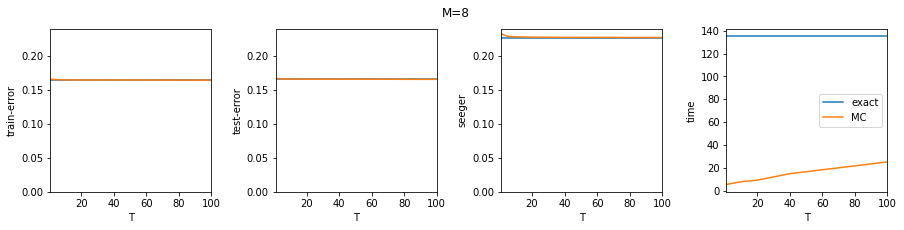

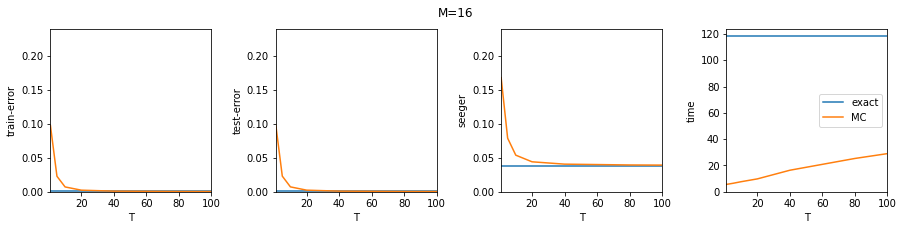

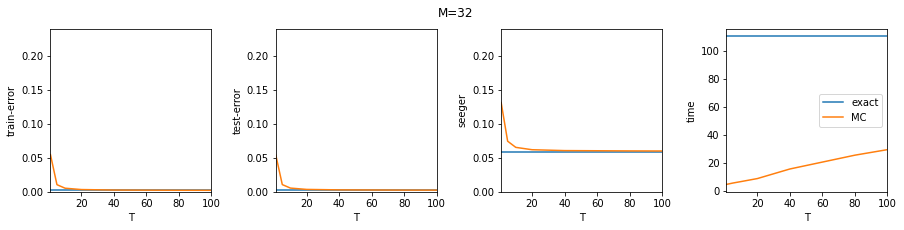

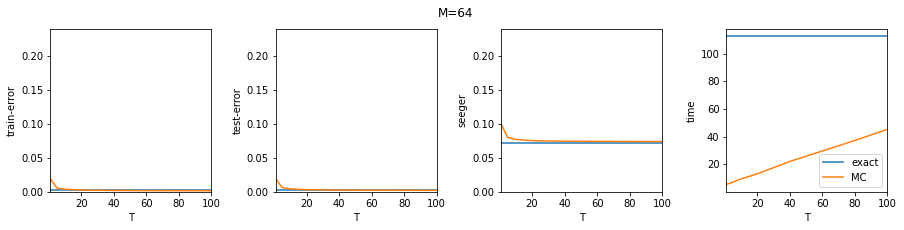

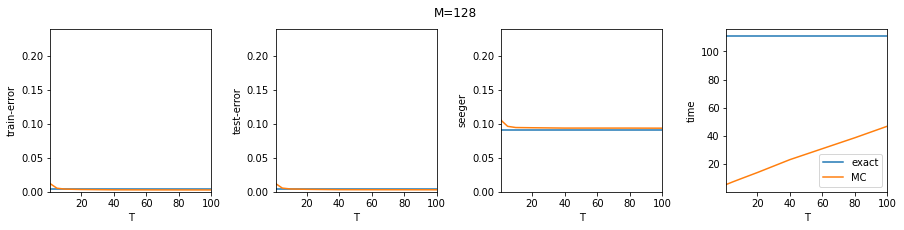

In [18]:
b = "seeger"

for m in ms:
    plt.figure(figsize=(15,3))

    for j, e in enumerate(["train-error", "test-error", b, "time"]):
        ax = plt.subplot(141 + j)

        plt.plot(ts, [results[m]["exact"][e][0]] * len(ts), label="exact")
#         plt.fill_between(ts, [results[n]["exact"][e][0] - results[n]["exact"][e][1]] * len(ts), [results[n]["exact"][e][0] + results[n]["exact"][e][1]] * len(ts), alpha=0.5)

        y = np.array([results[m]["MC"][t][e][0] for t in ts])
        err = np.array([results[m]["MC"][t][e][1] for t in ts])

        plt.plot(ts, y, label="MC")
#         plt.fill_between(ts, y-err, y+err, alpha=0.5)

        plt.xlim(min(ts), max(ts))    
        plt.ylabel(e)
        plt.xlabel("T")
        if e in ["train-error", "test-error", b]:
            plt.ylim(0, 0.24)

    plt.suptitle(f"M={m*4}")
    plt.subplots_adjust(wspace=0.4)
    plt.legend()
    
    plt.savefig(f"moons-n={n}-M={m}-all-T.pdf", bbox_inches="tight")